# MD-SCF simulation of lipid solution

**`By You-Liang Zhu`**

## Introduction

This tutorial provides an introduction of MD-SCF simulations using GALAMOST. It is designed for new users who want to learn about how to run MD-SCF simulations. It does however assume that you have a machine with GALAMOST correctly installed.

In this tutorial, we would like to make a system consisting of DPPC lipids and solvents to simulate the phase separation at different lipid concentrations.

**Download [running files](https://bitbucket.org/galamostdevelopergroup/source-code/src/master/examples/Case8-MDSCF-DPPC-in-Non-Lamellar-Phases/systemA/)**.

In order to run this MD-SCF simulation, two files should be prepared:
*  `filename.xml`: file describes the information (including position, velocity, topology, etc.) of the particles. More about [`XML` data format](https://galamost.readthedocs.io/en/latest/data-format.html). The initial configuration file `filename.xml` could be generated by `Molgen` plugin.
*  `filename.gala`: file describes the settings for the simulation.

## Prepare XML file by Molgen

A system contains two types of molecules, DPPC and solvent. In order to generate `XML` file, a python script of [`Molgen`](https://galamost.readthedocs.io/en/latest/molgen.html) plugin is needed. The DPPC and solvent molecules are initially randomly generated in a cubic box. The system information is written into `scfA.xml` file by following script. The coarse-grained model of DPPC is given: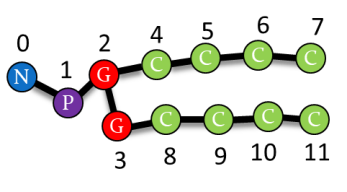

The [`Molgen`](https://galamost.readthedocs.io/en/latest/molgen.html) script "scfA.molg" is given:

In [ ]:
#!/usr/bin/python
import sys
sys.path.append('/opt/galamost3/lib')
import molgen

mol1=molgen.Molecule(12)#particle number
mol1.setParticleTypes("N,P,G,G,C,C,C,C,C,C,C,C") #with assigned id sequentially from 0 to 11
mol1.setTopology("0-1,1-2,2-3,2-4,3-8,4-5,5-6,6-7,8-9,9-10,10-11")
mol1.setBondLength(0.47)
mol1.setBondLength("G","G",0.37)
mol1.setMass(72.0)
mol1.setAngleDegree("P","G","G",120)# P-G-G with 120 degree
mol1.setAngleDegree("P","G","C",180)
mol1.setAngleDegree("G","C","C",180)
mol1.setAngleDegree("C","C","C",180)


gen0=molgen.Generators(12.964, 12.964, 12.964) # box size in x, y, and z directions
gen0.addMolecule(mol1, 1)
gen0.setMinimumDistance(0.42)
gen0.outPutXml("dppc")  # generate 1 molecule

mol1 = molgen.Object("dppc.xml", 12, molgen.Object.Shape.none)# all particles read from the file
mol2=molgen.Molecule(1)#number
mol2.setParticleTypes("W")
mol2.setMass(72.0)

gen=molgen.Generators(12.964, 12.964, 12.964) # box size in x, y, and z directions
gen.addMolecule(mol1, 1664) #number of molecules
gen.addMolecule(mol2, 1248) #nmber of molecules
gen.outPutXml("scfA")

The concentration of lipid in solution could be tuned by changing the number of the molecules.

## Prepare GALA file

GALA script "scfA.gala" that defines the program settings is given for MD-SCF run.

In [ ]:
#!/usr/bin/python
import sys
sys.path.append('/opt/galamost3/lib') # the path where the GALAMOST program is installed
import galamost
from optparse import OptionParser
 
global _options
parser = OptionParser()
parser.add_option('--gpu', dest='gpu',help='GPU on which to execute')
(_options, args) = parser.parse_args()
 
filename = 'scfA.xml'# initial configuration file
build_method = galamost.XmlReader(filename)
perform_config = galamost.PerformConfig(_options.gpu)# assign GPU by index
all_info = galamost.AllInfo(build_method,perform_config)# build system information
 
dt = 0.03
Temperature = 318.000  #k
T = Temperature*8.3143/1000.0#reduced unit
app = galamost.Application(all_info, dt)# build up an application with system information and integration time-step

# intra-molecular neighbor list
neighbor_list = galamost.IntraMoleList(all_info, 0.9000, 0.3000)#(rcut,rbuffer)
neighbor_list.addExclusionsFromBonds()

# intra-molecular interactions
lj = galamost.LjForce(all_info, neighbor_list, 0.9000)
lj.setParams('N', 'N',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('N', 'P',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('N', 'G',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('N', 'C',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('N', 'W',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('P', 'P',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('P', 'G',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('P', 'C',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('P', 'W',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('G', 'G',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('G', 'C',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('G', 'W',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('C', 'C',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('C', 'W',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
lj.setParams('W', 'W',  2.000,  0.470,  1.000)#(type,type,epsilon,sigma,alpha)
app.add(lj)

# MD-SCF inter-molecular force
scf = galamost.MdScfForce(all_info,    22,    22,    22, 0.100)#(mx,my,mz,compressibility)
scf.setParams('N', 'N',  0.000)#(chi)
scf.setParams('N', 'P', -1.500)#(chi)
scf.setParams('N', 'G',  6.300)#(chi)
scf.setParams('N', 'C',  9.000)#(chi)
scf.setParams('N', 'W', -8.130)#(chi)
scf.setParams('P', 'P',  0.000)#(chi)
scf.setParams('P', 'G',  4.500)#(chi)
scf.setParams('P', 'C', 13.500)#(chi)
scf.setParams('P', 'W', -3.600)#(chi)
scf.setParams('G', 'G',  0.000)#(chi)
scf.setParams('G', 'C',  6.300)#(chi)
scf.setParams('G', 'W',  4.500)#(chi)
scf.setParams('C', 'C',  0.000)#(chi)
scf.setParams('C', 'W', 33.750)#(chi)
scf.setParams('W', 'W',  0.000)#(chi)
scf.setPeriodScf(   1,  300)#(idl2_step, idl_step)
app.add(scf)

# bond stretching interaction by harmonic potential
bondforce = galamost.BondForceHarmonic(all_info)
bondforce.setParams('N-P',  1250.000,  0.470)#(,K0, R0)
bondforce.setParams('P-G',  1250.000,  0.470)#(,K0, R0)
bondforce.setParams('G-G',  1250.000,  0.370)#(,K0, R0)
bondforce.setParams('G-C',  1250.000,  0.470)#(,K0, R0)
bondforce.setParams('C-C',  1250.000,  0.470)#(,K0, R0)
app.add(bondforce)

# angle bending interaction 
angleforce = galamost.AngleForceHarmonicCos(all_info)
angleforce.setParams('P-G-G',   25.000, 120.000)#(,K0, t0(degree))
angleforce.setParams('P-G-C',   25.000, 180.000)#(,K0, t0(degree))
angleforce.setParams('G-C-C',   25.000, 180.000)#(,K0, t0(degree))
angleforce.setParams('C-C-C',   25.000, 180.000)#(,K0, t0(degree))
app.add(angleforce)

group = galamost.ParticleSet(all_info, "all")# a collection of particles
comp_info = galamost.ComputeInfo(all_info, group)  # calculating system informations, such as temperature, pressure, and momentum
thermo = galamost.AndersenNvt(all_info, group, T, 7.000, 1234)#( ,temperature, coll_freq, random seed)
app.add(thermo)

DInfo = galamost.DumpInfo(all_info, comp_info, 'data.log')# output system informations, such as temperature, pressure, and momentum
DInfo.setPeriod(200)
app.add(DInfo)
 
mol2 = galamost.Mol2Dump(all_info, 'particles')# output the configuration files in mol2 format
mol2.setPeriod(100000)# (period)
mol2.deleteBoundaryBond(True)# (period)
app.add(mol2)
 
dcd = galamost.DcdDump(all_info, 'particles',True)# output the configuration files in DCD format
dcd.setPeriod(10000)# (period)
dcd.unwrap(True)
app.add(dcd)
 
xml = galamost.XmlDump(all_info, 'particles') # output the configuration files in xml format
xml.setPeriod(100000)# (period)
xml.setOutputBond(True)
xml.setOutputImage(True)
app.add(xml)

#ready ro run
app.run( 20000000)#(the number of steps to run)

[OVITO](http://www.ovito.org/) is suggested to render the pictures of system snapshots with the output XML files

For further calculation of properties, GALAMOST plugin [`galaTackle`](https://galamost.readthedocs.io/en/latest/galatackle.html) can be used, which can be find in `galamost installed path\bin`.

In [ ]:
galaTackle *.xml
1